In [1]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

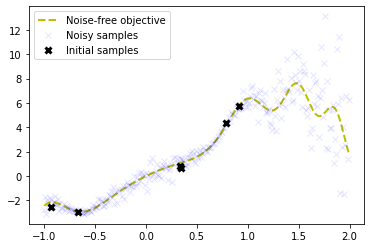

In [3]:
noise = 1

def f(X, noise=noise):
    return (-torch.sin(5*X**2) - X**4 + 0.3 *X** 3 + 2 * X **2 + 4.1*X + 
            noise * torch.randn_like(X) * (.5 - X ** 2))

def repeat(f, bounds):
    new_bounds = (bounds[0], 2 * bounds[1] - bounds[0])
    def g(X, noise=noise):
        return (X < bounds[1]) * f(X, noise) + (X >= bounds[1]) * (f(X - bounds[1] + bounds[0], noise) + 
                                                                  f(torch.FloatTensor([bounds[1]]), 0) -
                                                                   f(torch.FloatTensor([bounds[0]]), 0))
    return g, new_bounds
    

bounds = (-1, 2)
# f, bounds = repeat(f, bounds)
# f, bounds = repeat(f, bounds)

X_init = (bounds[1] - bounds[0]) * torch.rand(6, 1) + bounds[0]
Y_init = f(X_init)

X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
Y = f(X, 0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [6]:
def optimize(model_name, plot=False, n_steps=5, **kwargs):
    train_X = X_init
    train_Y = Y_init


    state_dict = None
    max_value_per_step = [train_Y.max().item()]
    for _ in range(n_steps):
        if model_name == EpistemicPredictor:

            ood_X = (bounds[1] - bounds[0]) * torch.rand(5, 1) + bounds[0]
            additional_data = {'ood_X': ood_X,
                       'ood_Y': f(ood_X),
                       'train_Y_2': f(train_X)}
            model = model_name(train_X, train_Y, additional_data, **kwargs)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            for _ in range(15):
                model.fit()
        elif model_name == SingleTaskGP:
            model = model_name(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            fit_gpytorch_model(mll)
        else:
            raise Exception('Not sure this would work !')

        EI = ExpectedImprovement(model, train_Y.max().item())
        eis = EI(X.unsqueeze(1)).detach()
        max_ei, argmax_ei = torch.max(eis, 0)
        xmax = X[argmax_ei].item()
        max_ei = max_ei.item()

        bounds_t = torch.FloatTensor([[bounds[0]], [bounds[1]]])
        candidate, acq_value = optimize_acqf(
            EI, bounds=bounds_t, q=1, num_restarts=5, raw_samples=50,
        )

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
            # Plot optimization objective with noise level
            ax1.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
            ax1.plot(X, f(X), 'rx', lw=1, alpha=0.2, label='Noisy samples')
            ax1.plot(train_X, train_Y, 'kx', mew=3, label='Initial samples')

            ax1.plot(X, model(X).mean.detach().squeeze(), label='mean pred')
            ax1.fill_between(X.numpy().ravel(),
                             model(X).mean.detach().numpy().ravel() - model(X).stddev.detach().numpy().ravel(),
                             model(X).mean.detach().numpy().ravel() + model(X).stddev.detach().numpy().ravel(),
                             alpha=.4)

            if isinstance(model, EpistemicPredictor):
                ax1.plot(X, model.density_estimator.score_samples(X), 'r-', label='density')

            ax2.plot(X, eis, 'r-', label='EI')
            ax2.plot(X, [max_ei] * len(X), 'b--')
            ax2.plot([xmax] * 100, torch.linspace(0, max_ei, 100), 'b--')
            ax1.legend()
            ax2.legend()

            plt.show()
            
        train_X = torch.cat([train_X, candidate])
        train_Y = torch.cat([train_Y, f(candidate)])
        if model_name == EpistemicPredictor:
            additional_data['train_Y_2'] = torch.cat([additional_data['train_Y_2'], f(candidate)])
        state_dict = model.state_dict()

        max_value_per_step.append(train_Y.max().item())

    return max_value_per_step

In [ ]:
density_estimator = FixedKernelDensityEstimator('exponential', 0.1)
networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
            'e_predictor': create_network(2, 1, 64, 'relu', True),
            'f_predictor': create_network(1, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }


optimize(EpistemicPredictor, plot=True, n_steps=20, networks=networks, optimizers=optimizers, density_estimator=density_estimator)
# optimize(SingleTaskGP, plot=True, n_steps=20)

In [ ]:
import numpy as np
n_runs = 5
n_steps = 25
gp_runs = np.zeros((n_runs, n_steps + 1))
ep_runs = np.zeros((n_runs, n_steps + 1))

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}")
    gp_runs[i] = optimize(SingleTaskGP, plot=False, n_steps=n_steps)
    density_estimator = FixedKernelDensityEstimator('exponential', 0.1)
    networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
                'e_predictor': create_network(2, 1, 64, 'relu', True),
                'f_predictor': create_network(1, 1, 64, 'relu', False)
                }

    optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
                  'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
                  'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
                  }
    ep_runs[i] = optimize(EpistemicPredictor, plot=False, n_steps=n_steps, networks=networks, optimizers=optimizers, density_estimator=density_estimator)

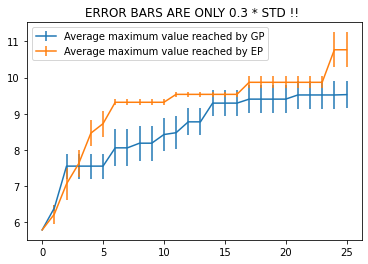

In [16]:
plt.errorbar(range(1 + n_steps), gp_runs.mean(0), .3 * gp_runs.std(0), label='Average maximum value reached by GP')
plt.errorbar(range(1 + n_steps), ep_runs.mean(0), .3 * ep_runs.std(0), label='Average maximum value reached by EP')
plt.legend()
plt.title('ERROR BARS ARE ONLY 0.3 * STD !! ')
plt.show()